# colab settings:


In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download to Colab from Google Drive:
# https://drive.google.com/open?id=YOUR_FILE_ID
download = drive.CreateFile({'id': '10AWC5jfxqdDXode3_1vkDKZpWVeAROV4'}) # 'id': 'YOUR_FILE_ID'
download.GetContentFile('dataset.tar')

In [0]:
!tar -xvf dataset.tar

In [11]:
!ls

adc.json  dataset.tar  INRIAPerson  sample_data


# Example of detection pedestrians with HOG and SVM from  OpenCV 


Pedestrian Detection OpenCV:  https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/

Sliding window: https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/ - find objects in images in various locations

Non-Maximum Suppression (NMS): https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python

Image Pyramids:  https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/ - find objects in images at different scales

Six steps algorithm: https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/

hog.detectMultiScale: https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/


In [0]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
from imutils import resize
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from skimage import data, color, exposure
#from skimage.feature import hog
from skimage.io import imread
from skimage.transform import pyramid_gaussian

from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from PIL import Image, ImageDraw

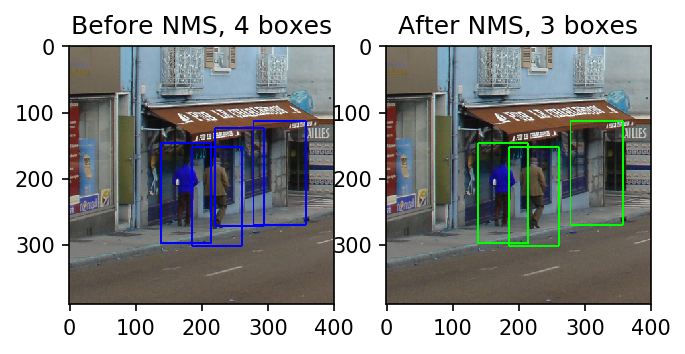

In [12]:
# initialize the HOG descriptor and pre-trained SVM pedestrian detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# load the image and resize it to (1) reduce detection time
# and (2) improve detection accuracy
image = cv2.imread('INRIAPerson/Test/pos/crop001504.png')
image = resize(image, width=min(400, image.shape[1]))
orig = image.copy()

# detect people in the image
# sliding window is fixed at 64 x 128 pixels
(rects, weights) = hog.detectMultiScale(image, winStride=(4, 4), # sliding window step size
                                        padding=(8, 8),
                                        scale=1.05) # scale of image pyramid (larger -> less layers, faster)
                                        

# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

# apply non-maxima suppression to the bounding boxes 
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, 
                           overlapThresh=0.4) # large overlap ensures that the bounding boxes are not suppressed

# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

# show the output images and some information on the number of bounding boxes

%matplotlib inline

plt.figure(dpi=150, figsize=(5, 5))
plt.subplot(121)
plt.title("Before NMS, {} boxes".format(len(rects)))
plt.imshow(orig)

plt.subplot(122)
plt.title("After NMS, {} boxes".format(len(pick)))
plt.imshow(image)

plt.show()

# Train SVM+HOG classifier from sklearn on INRIA dataset 

DATASET: http://pascal.inrialpes.fr/data/human/

HOG: https://www.learnopencv.com/histogram-of-oriented-gradients/

add links and some description

https://github.com/SamPlvs/Object-detection-via-HOG-SVM


In [0]:
# define parameters of HOG feature extraction
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3
# 9 * 4(16x16 / 8x8) = 36 
# 36 * 105 (7 * 15 - pos of 16x16) 3780

# define size for train and test data
PERSON_WIDTH = 64
PERSON_HEIGHT = 128
leftop_train = [16, 16]
rightbottom_train = [16 + PERSON_WIDTH, 16 + PERSON_HEIGHT]
leftop_test = [3, 3]
rightbottom_test = [3 + PERSON_WIDTH, 3 + PERSON_HEIGHT]

In [13]:
from skimage.feature import hog
# define path to images:
train_pos_img_dir = 'INRIAPerson/train_64x128_H96/pos/'
train_neg_img_dir = 'INRIAPerson/train_64x128_H96/neg/'
test_pos_img_dir = 'INRIAPerson/test_64x128_H96/pos/'
test_neg_img_dir = 'INRIAPerson/test_64x128_H96/neg/'

# read the image files:
train_pos_images = os.listdir(train_pos_img_dir)
train_neg_images = os.listdir(train_neg_img_dir)
test_pos_images = os.listdir(test_pos_img_dir)
test_neg_images = os.listdir(test_neg_img_dir)

trainData = []
testData = []
trainLabels = []
testLabels = []

#loading train data
print('loading ' + str(len(train_pos_images)) + ' positive images [Train]')
for train_pos_image in train_pos_images:
    pos_img = data.imread(train_pos_img_dir + train_pos_image, as_gray=True)
    pos_roi = pos_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    fd = hog(pos_roi, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    trainData.append(fd)
    trainLabels.append(1)
    
print('loading ' + str(len(train_neg_images)) + ' negative images [Train]')
for train_neg_image in train_neg_images:
    neg_img = data.imread(train_neg_img_dir + train_neg_image, as_gray=True)
    neg_roi = neg_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    fd = hog(neg_roi, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    trainData.append(fd)
    trainLabels.append(0)
    
#loading test data    
print('loading ' + str(len(test_pos_images)) + ' positive images [Test]')
for test_pos_image in test_pos_images:
    pos_img = data.imread(test_pos_img_dir + test_pos_image, as_gray=True)
    pos_roi = pos_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    fd = hog(pos_roi, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    testData.append(fd)
    testLabels.append(1)
    
print('loading ' + str(len(test_neg_images)) + ' negative images [Test]')
for test_neg_image in test_neg_images:
    neg_img = data.imread(test_neg_img_dir + test_neg_image, as_gray=True)
    neg_roi = neg_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    fd = hog(neg_roi, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    testData.append(fd)
    testLabels.append(0)  
    

loading 2416 positive images [Train]
loading 1218 negative images [Train]
loading 1132 positive images [Test]
loading 453 negative images [Test]
Train data size: (3634, 3780)
Test data size: (1585, 3780)


In [17]:
print ('Train data size: {}'.format(np.asarray(trainData).shape))
print ('Test data size: {}'.format(np.asarray(testData).shape))

Train data size: (3634, 3780)
Test data size: (1585, 3780)


In [0]:
X = np.concatenate((trainData, testData), axis=0)
y = np.concatenate((trainLabels, testLabels), axis=0)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True,)

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


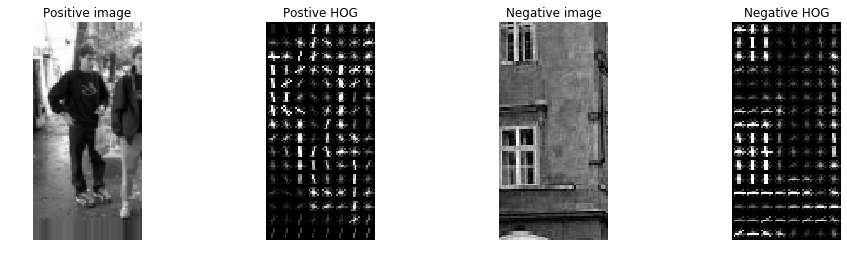

In [14]:
# show sample of the image before and after HOG aplication
fd, pos_hog_image = hog(pos_roi, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2), visualise=True)
pos_hog_image = exposure.rescale_intensity(pos_hog_image, in_range=(0, 0.1))

fd, neg_hog_image = hog(neg_roi, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2), visualise=True)
neg_hog_image = exposure.rescale_intensity(neg_hog_image, in_range=(0, 0.1))

plt.figure(figsize=(16, 4))

plt.subplot(141).set_axis_off()
plt.imshow(pos_roi, cmap=plt.cm.gray)
plt.title('Positive image')
plt.subplot(142).set_axis_off()
plt.imshow(pos_hog_image, cmap=plt.cm.gray)
plt.title('Postive HOG')

plt.subplot(143).set_axis_off()
plt.imshow(neg_roi, cmap=plt.cm.gray)
plt.title('Negative image')
plt.subplot(144).set_axis_off()
plt.imshow(neg_hog_image, cmap=plt.cm.gray)
plt.title('Negative HOG')
plt.show()

In [20]:
# encode the labels, converting them from strings to integers
#le = LabelEncoder()
#labels = le.fit_transform(trainLabels)
#labels = le.fit_transform(testLabels)

# train the linear SVM
print("Linear SVM classifier:")
model = LinearSVC()
model.fit(X_train, y_train)

# evaluate the classifier
predictions = model.predict(X_val)
print(classification_report(y_val, predictions))

# save the model
joblib.dump(model, 'LinearSVC_HOG.npy')

Linear SVM classifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       172
           1       1.00      0.99      0.99       350

   micro avg       0.99      0.99      0.99       522
   macro avg       0.99      0.99      0.99       522
weighted avg       0.99      0.99      0.99       522



['LinearSVC_HOG.npy']

In [21]:
from sklearn.metrics import confusion_matrix

# confusion matrix
# tn fp
# fn tp
matrix = confusion_matrix(y_val, predictions)
print(matrix)

[[171   1]
 [  3 347]]


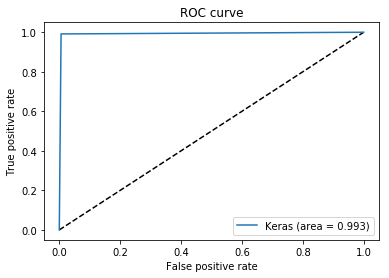

In [22]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Detection of pedestrian

### parametrs:

    downscale for pyramid

    stepSize for sliding window

    thershold for decision_function ???

    overlapThresh for non_max_suppression

    initial image size ??? 



In [0]:
# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/pyth

detection confidence score:  [1.9085074699209703, 2.2921363217136737, 2.3087245140355988, 1.743500358554778, 2.7405922715805735, 1.7687443666944032, 2.0261952668254097, 2.646214902158251, 3.4280116594529724, 1.9932991217209128, 1.9066946975370245, 2.6874509406047005, 2.17961119889297, 1.7367442487707496, 2.1292125135892923, 1.815320352914759, 1.7797526366328116, 1.9931288263004245, 1.7520010451081065, 1.7083457643637199]


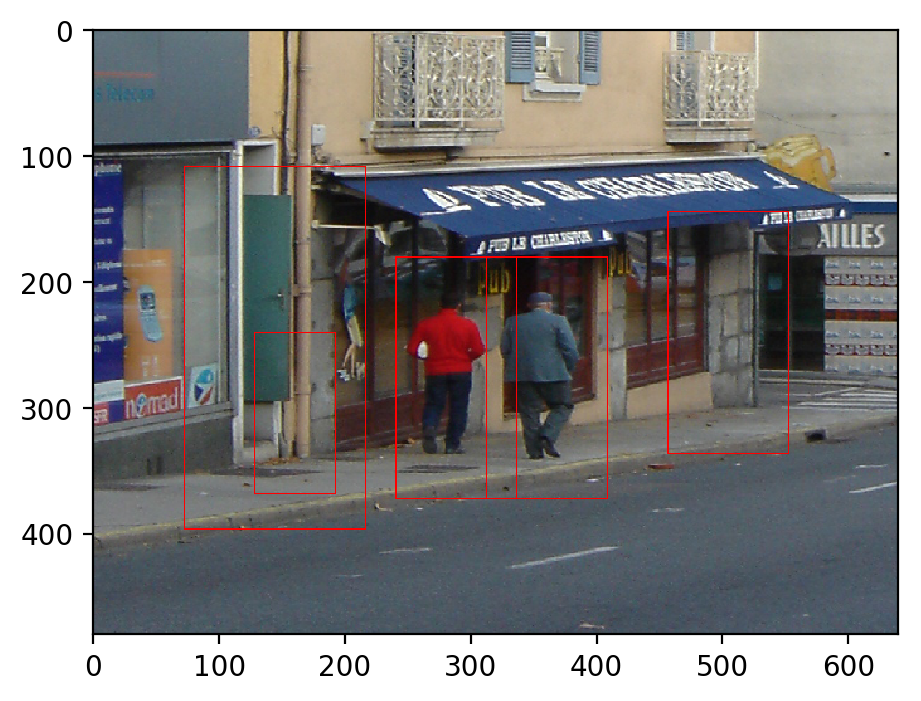

In [0]:
%matplotlib inline

# upload the saved svm model:
model = joblib.load('LinearSVC_HOG.npy')

# test the trained classifier on an image below!
scale = 0
detections = []

# read the image you want to detect the object in:
image = Image.open('INRIAPerson/Test/pos/crop001504.png')

# resize image if it is too big
image = image.resize((640,480)) 

# defining the size of the sliding window 
(winW, winH) = (64,128)
windowSize =(winW,winH)
downscale =1.5

# Apply sliding window:
for resized in pyramid_gaussian(image, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=8, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        window=color.rgb2gray(window)
        fds = hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2', multichannel=False)  # extract HOG features from the window captured
        fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred == 1:
            if model.decision_function(fds) > 1.7:  #set a threshold value for the SVM prediction 
               # print("Detection:: Location -> ({}, {})".format(x, y))
               # print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
    
draw = ImageDraw.Draw(image)    
clone = resized.copy()

#for (x_tl, y_tl, _, w, h) in detections:
  #  draw.rectangle([x_tl, y_tl, x_tl + w, y_tl + h], outline=(255, 0, 0))
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)

sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)

# Start drawing rectangles for each possible detection
for (xA, yA, xB, yB) in pick:
    draw.rectangle([xA, yA, xB, yB], outline=(255, 0, 0))

#image.show()
#imshow(np.asarray(image))

plt.figure(dpi=200)
plt.imshow(image)